In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )


In [3]:
from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()


# LOAD QPU

In [4]:
import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260205-2239_co_spec0203


# Connection

In [5]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=True)
#session.disconnect()

[2026.02.09 15:25:16.539] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.09 15:25:16.540] INFO    VERSION: laboneq 25.10.3
[2026.02.09 15:25:16.541] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.09 15:25:16.542] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.09 15:25:16.543] INFO    Configuring the device setup
[2026.02.09 15:25:16.549] INFO    The device setup is configured


# Two-tone SG sampled modulation for RIP
SG 채널의 baseband에서 2-tone을 직접 합성한 sampled pulse를 만들고,
이를 bus RIP(qop.rip)에 적용합니다.

https://docs.zhinst.com/shfqc_user_manual/specifications.html

instantaneous bandwidth (-3dB) :  $\pm 500 \mathrm{MHz}$ for RF path


In [6]:

# bare mode frequency obtained from coherencen_spectroscopy_echo experiments
buses[0].parameters.resonance_frequency_bus = 5.5052e9
print(buses[0].rip_parameters())
buses[1].parameters.resonance_frequency_bus = 5.9799e9 
print(buses[1].rip_parameters())


buses[0].parameters.drive_lo_frequency = 5.8e9
buses[1].parameters.drive_lo_frequency = 5.8e9

buses[0].parameters.rip_detuning = -20e6 #-20Mhz
buses[1].parameters.rip_detuning = -20e6

print(buses[0].parameters.rip_detuning* 1e-6) # In MHz
print(buses[1].parameters.rip_detuning *1e-6)

('drive', {'amplitude': 1.0, 'length': 1e-06, 'pulse': {'function': 'NestedCosine'}})
('drive', {'amplitude': 1.0, 'length': 1e-06, 'pulse': {'function': 'NestedCosine'}})
-20.0
-20.0


In [13]:
import matplotlib.pyplot as plt
from laboneq.simple import dsl

SR = 2.0e9  # SG sampling rate (Hz)

def make_two_tone_samples(length, f_if_1, f_if_2, amp_1=0.35, amp_2=0.35, phase_1=0.0, phase_2=0.0, rise_fall=20e-9):
    # Create complex baseband samples with smooth sin^2 edges.
    n = int(round(length * SR))
    t = np.arange(n) / SR

    env = np.ones(n)
    n_edge = max(8, int(round(rise_fall * SR)))
    if 2 * n_edge < n:
        edge = np.sin(0.5 * np.pi * np.linspace(0, 1, n_edge)) ** 2
        env[:n_edge] = edge
        env[-n_edge:] = edge[::-1]

    samples = env * (
        amp_1 * np.exp(1j * (2 * np.pi * f_if_1 * t + phase_1))
        + amp_2 * np.exp(1j * (2 * np.pi * f_if_2 * t + phase_2))
    )

    peak = np.max(np.abs(samples))
    if peak > 1.0:
        print("WARNING! clipping required")
        samples = samples / peak
    return t, samples

# RIP pulse parameters
rip_len = 800e-9 

# b0: RF tones and center frequency (set_bus_frequency target)

f0_rf_1 = buses[0].parameters.resonance_frequency_bus + buses[0].parameters.rip_detuning
f0_rf_2 = buses[1].parameters.resonance_frequency_bus + buses[1].parameters.rip_detuning

f0_center = buses[0].parameters.drive_lo_frequency#0.5 * (f0_rf_1 + f0_rf_2)
f0_if_1 = buses[0].parameters.drive_frequency_bus
f0_if_2 = buses[1].parameters.drive_frequency_bus

t0, samples_b0 = make_two_tone_samples(rip_len, f0_if_1, f0_if_2, amp_1=0.35, amp_2=0.35)

# b1: second RIP line example (same IF spacing, shifted RF center)

f1_rf_1 = buses[0].parameters.resonance_frequency_bus + buses[0].parameters.rip_detuning
f1_rf_2 = buses[1].parameters.resonance_frequency_bus + buses[1].parameters.rip_detuning


f1_center = buses[1].parameters.drive_lo_frequency #0.5 * (f1_rf_1 + f1_rf_2) #This should be LO frequency
f1_if_1 = buses[0].parameters.drive_frequency_bus # this should be bus_bare_freq + detuning -lo freq
f1_if_2 = buses[1].parameters.drive_frequency_bus #likewise 

t1, samples_b1 = make_two_tone_samples(rip_len, f1_if_1, f1_if_2, amp_1=0.35, amp_2=0.35)

# Attach sampled pulses to bus parameters (used by qop.rip)
buses[0].parameters.rip_length = rip_len
buses[0].parameters.rip_pulse = {
    "function": "sampled_pulse",
    "samples": samples_b0,
}

buses[1].parameters.rip_length = rip_len
buses[1].parameters.rip_pulse = {
    "function": "sampled_pulse",
    "samples": samples_b1,
}

print("b0 center/IF (MHz):", f0_center * 1e-6, f0_if_1 * 1e-6, f0_if_2 * 1e-6)
print("b1 center/IF (MHz):", f1_center * 1e-6, f1_if_1 * 1e-6, f1_if_2 * 1e-6)
print("num samples:", len(samples_b0))


b0 center/IF (MHz): 5800.0 -314.8 159.9
b1 center/IF (MHz): 5800.0 -314.8 159.9
num samples: 1600


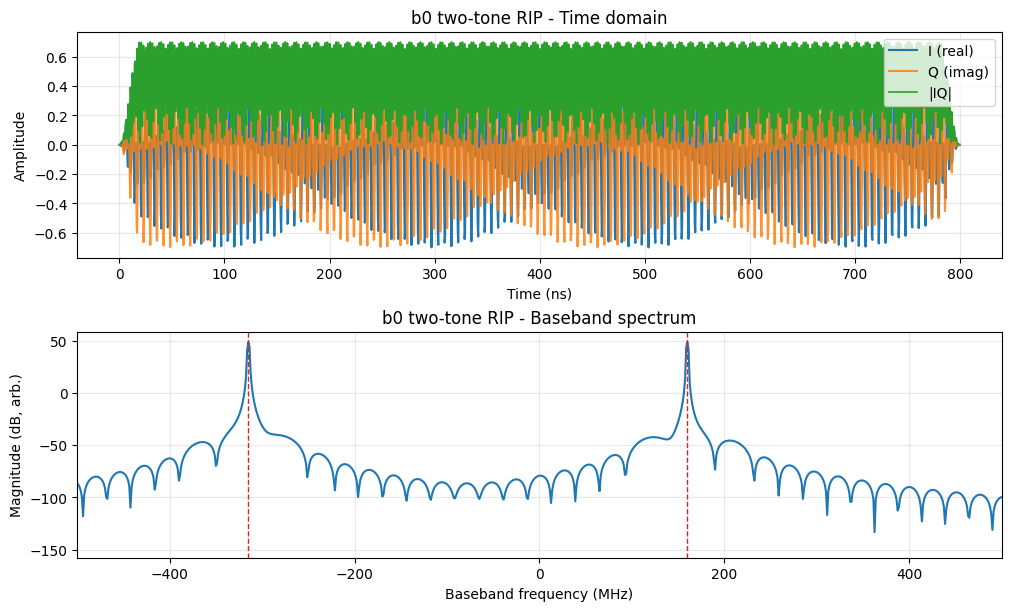

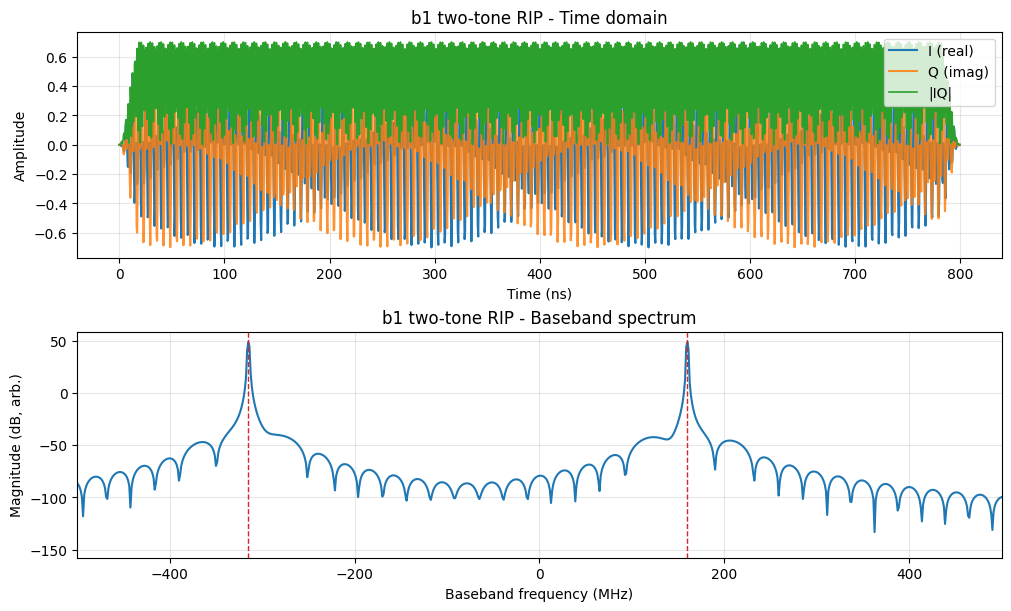

In [8]:
# Plot modulated pulse shape (time domain) + baseband spectrum

def plot_samples_and_spectrum(t, samples, if_targets_hz, title=""):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)

    axes[0].plot(t * 1e9, samples.real, label="I (real)")
    axes[0].plot(t * 1e9, samples.imag, label="Q (imag)", alpha=0.85)
    axes[0].plot(t * 1e9, np.abs(samples), label="|IQ|", lw=1.2)
    axes[0].set_xlabel("Time (ns)")
    axes[0].set_ylabel("Amplitude")
    axes[0].set_title(f"{title} - Time domain")
    axes[0].grid(alpha=0.3)
    axes[0].legend(loc="upper right")

    n = len(samples)
    win = np.hanning(n)
    spec = np.fft.fftshift(np.fft.fft(samples * win))
    freq = np.fft.fftshift(np.fft.fftfreq(n, d=1 / SR))

    axes[1].plot(freq * 1e-6, 20 * np.log10(np.abs(spec) + 1e-12))
    for f_if in if_targets_hz:
        axes[1].axvline(f_if * 1e-6, color="tab:red", ls="--", lw=1)
    axes[1].set_xlim(-500, 500)
    axes[1].set_xlabel("Baseband frequency (MHz)")
    axes[1].set_ylabel("Magnitude (dB, arb.)")
    axes[1].set_title(f"{title} - Baseband spectrum")
    axes[1].grid(alpha=0.3)

    plt.show()

plot_samples_and_spectrum(t0, samples_b0, [f0_if_1, f0_if_2], title="b0 two-tone RIP")
plot_samples_and_spectrum(t1, samples_b1, [f1_if_1, f1_if_2], title="b1 two-tone RIP")


In [11]:
@dsl.qubit_experiment
def build_two_rip_exp(qpu, b0, b1):
    qop = qpu.quantum_operations

    with dsl.acquire_loop_rt(
        count=1,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        with dsl.section(name="two_rip_play", alignment=SectionAlignment.LEFT):
            # One center frequency per SG signal line
            qop.set_bus_frequency(b0, f0_center, rf=True)
            qop.set_bus_frequency(b1, f1_center, rf=True)

            qop.rip(b0, amplitude=1.0)
            #qop.rip(b1, amplitude=1.0)

exp = build_two_rip_exp(qpu, buses[0], buses[1])
compiled = session.compile(exp)
print("compile ok:", type(compiled))


[2026.02.09 15:25:42.751] INFO    Resolved modulation type of oscillator 'b0_drive_osc' on signal 'b0/drive' to HARDWARE
[2026.02.09 15:25:42.752] INFO    Resolved modulation type of oscillator 'b1_drive_osc' on signal 'b1/drive' to HARDWARE
[2026.02.09 15:25:42.753] INFO    Starting LabOne Q Compiler run...
[2026.02.09 15:25:42.755] INFO    Schedule completed. [0.001 s]
[2026.02.09 15:25:42.757] INFO    Code generation completed for all AWGs. [0.001 s]
[2026.02.09 15:25:42.757] INFO    Completed compilation step 1 of 1. [0.003 s]
[2026.02.09 15:25:42.759] INFO     ─────────────────────────────────────────────────────────────────────── 
[2026.02.09 15:25:42.759] INFO      Device              AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2026.02.09 15:25:42.759] INFO     ─────────────────────────────────────────────────────────────────────── 
[2026.02.09 15:25:42.760] INFO      SHFQC_DEV12256_sg     4          8            2           1      3200  
[2026.02.09 15:25:42.760] INFO 

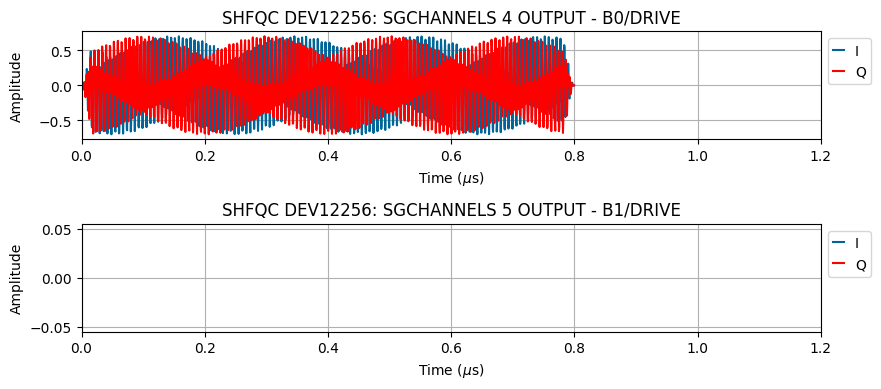

In [12]:
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# Check compiled waveform with two-tone sampled modulation
plot_simulation(compiled_experiment=compiled, length=1.2e-6)
